# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [3]:
X_train = X_train.transpose(0, 3, 2, 1)
X_test = X_test.transpose(0, 3, 2, 1)


In [4]:
print X_train.shape
print X_test.shape

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [5]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]
X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [6]:
print X_train.shape, y_train.shape
print X_val.shape, y_val.shape

(40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000,)


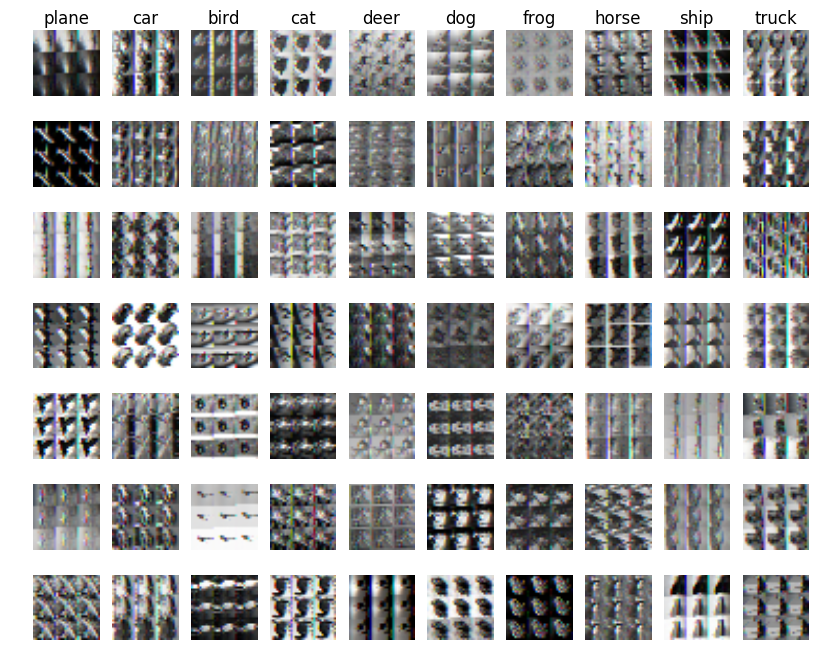

In [7]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int64')

Так задаётся архитектура нейронки

In [9]:
input_layer = lasagne.layers.InputLayer(shape=(None,3, 32, 32), input_var=input_X)

#layer_1 = lasagne.layers.Conv2DLayer(input_layer, 10, (3,3), nonlinearity=leaky_rectify, pad='same')
#layer_2 = lasagne.layers.Conv2DLayer(input_layer, 10, (5,5), nonlinearity=leaky_rectify, pad='same')
#layer_3 = lasagne.layers.Conv2DLayer(input_layer, 4, (7,7), nonlinearity=leaky_rectify, pad='same')
#network = lasagne.layers.ConcatLayer([layer_1, layer_2],1)

network = lasagne.layers.Conv2DLayer(input_layer, 64, (3,3), nonlinearity=leaky_rectify, pad='same')
network = lasagne.layers.Conv2DLayer(network, 64, (3,3), nonlinearity=leaky_rectify, pad='same')
network = lasagne.layers.MaxPool2DLayer(network, (2,2))

#layer_1 = lasagne.layers.Conv2DLayer(network, 20, (3,3), nonlinearity=leaky_rectify, pad='same')
#layer_2 = lasagne.layers.Conv2DLayer(network, 20, (5,5), nonlinearity=leaky_rectify, pad='same')
#network = lasagne.layers.ConcatLayer([layer_1, layer_2],1)

network = lasagne.layers.Conv2DLayer(network, 128, (3,3), nonlinearity=leaky_rectify, pad='same')
network = lasagne.layers.MaxPool2DLayer(network, (2,2))

network = lasagne.layers.Conv2DLayer(input_layer, 128, (3,3), nonlinearity=leaky_rectify, pad='same')
network = lasagne.layers.MaxPool2DLayer(network, (2,2))

network = lasagne.layers.Conv2DLayer(network, 256, (3,3), nonlinearity=leaky_rectify)

network = lasagne.layers.MaxPool2DLayer(network, (2,2))

network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=300,
            nonlinearity=leaky_rectify)

network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=150,
            nonlinearity=leaky_rectify)
#network = lasagne.layers.Conv2DLayer(network, 8, (5,5), nonlinearity=leaky_rectify)
# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
dense_output = lasagne.layers.DenseLayer(lasagne.layers.dropout(network, p=.5),
                                         num_units = 10, nonlinearity=softmax)

In [10]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output, deterministic = 'True')
y_predicted_train = lasagne.layers.get_output(dense_output, deterministic = 'False')

In [11]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [12]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted_train,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

In [13]:
updates = lasagne.updates.adam(loss, all_weights)

train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [14]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [15]:
epoch_count = 2

In [16]:
import time

num_epochs = 40 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    epoch_count += 1
    count = 0
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        count += 1
        if count%100 == 0:
            print count
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch_count, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

100
200
300
400
500
600
700
800
Epoch 3 of 40 took 2124.535s
  training loss (in-iteration):		2.277089
  train accuracy:		44.92 %
  validation accuracy:		52.75 %
100
200
300
400
500
600
700
800
Epoch 4 of 40 took 2159.614s
  training loss (in-iteration):		1.149485
  train accuracy:		59.54 %
  validation accuracy:		56.35 %
100
200
300
400
500
600
700
800
Epoch 5 of 40 took 2066.305s
  training loss (in-iteration):		0.982477
  train accuracy:		65.57 %
  validation accuracy:		57.67 %
100
200
300
400
500
600
700
800
Epoch 6 of 40 took 2121.070s
  training loss (in-iteration):		0.870889
  train accuracy:		69.46 %
  validation accuracy:		57.11 %
100
200
300
400
500
600
700
800
Epoch 7 of 40 took 2135.515s
  training loss (in-iteration):		0.766378
  train accuracy:		73.46 %
  validation accuracy:		61.92 %
100
200
300
400
500
600
700
800
Epoch 8 of 40 took 2097.748s
  training loss (in-iteration):		0.660619
  train accuracy:		77.08 %
  validation accuracy:		60.00 %
100
200
300
400
500
600
700


KeyboardInterrupt: 

In [33]:
lasagne.layers.get_all_param_values(dense_output)

[array([[[[ 0.00141741, -0.07010687, -0.03603172],
          [-0.07403091, -0.0870429 ,  0.00672803],
          [-0.05860067,  0.02314697, -0.00189548]],
 
         [[-0.03175984, -0.00426882, -0.07394088],
          [ 0.0351456 ,  0.00164603, -0.06463529],
          [ 0.01990763, -0.03792972, -0.06085941]],
 
         [[-0.03011158,  0.02226635, -0.01827529],
          [-0.0129174 , -0.07687671,  0.0270921 ],
          [-0.04263795, -0.00993058, -0.01979479]]],
 
 
        [[[ 0.06038991,  0.01610985,  0.06485344],
          [-0.01378385, -0.04521669, -0.032844  ],
          [-0.09248846, -0.06513468, -0.02332424]],
 
         [[ 0.02620514, -0.09455224, -0.01332735],
          [-0.09346176, -0.03275866,  0.00554979],
          [-0.02582624,  0.06822463,  0.0045816 ]],
 
         [[-0.00260779, -0.11136264, -0.03873286],
          [-0.03679375, -0.02147044, -0.00026872],
          [ 0.02766761,  0.05331642,  0.01246254]]],
 
 
        [[[-0.02502646, -0.01017628,  0.02601853],
       

In [17]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		64.33 %
Нужно больше магии!


SyntaxError: invalid syntax (<ipython-input-18-6d585b803b38>, line 1)

In [29]:
import cPickle
def save_network(filename,param_values):
    f = file(filename, 'wb')
    cPickle.dump(param_values,f,protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

def load_network(filename):
    f = file(filename, 'rb')
    param_values = cPickle.load(f)
    f.close()
    return param_values

In [30]:
save_network("my beloved_network",lasagne.layers.get_all_param_values(dense_output))

In [31]:
load_network("my beloved_network")

[array([[[[ 0.00141741, -0.07010687, -0.03603172],
          [-0.07403091, -0.0870429 ,  0.00672803],
          [-0.05860067,  0.02314697, -0.00189548]],
 
         [[-0.03175984, -0.00426882, -0.07394088],
          [ 0.0351456 ,  0.00164603, -0.06463529],
          [ 0.01990763, -0.03792972, -0.06085941]],
 
         [[-0.03011158,  0.02226635, -0.01827529],
          [-0.0129174 , -0.07687671,  0.0270921 ],
          [-0.04263795, -0.00993058, -0.01979479]]],
 
 
        [[[ 0.06038991,  0.01610985,  0.06485344],
          [-0.01378385, -0.04521669, -0.032844  ],
          [-0.09248846, -0.06513468, -0.02332424]],
 
         [[ 0.02620514, -0.09455224, -0.01332735],
          [-0.09346176, -0.03275866,  0.00554979],
          [-0.02582624,  0.06822463,  0.0045816 ]],
 
         [[-0.00260779, -0.11136264, -0.03873286],
          [-0.03679375, -0.02147044, -0.00026872],
          [ 0.02766761,  0.05331642,  0.01246254]]],
 
 
        [[[-0.02502646, -0.01017628,  0.02601853],
       

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3